# Simple ellipsoid
In this demo we show how to inflate and contract a simple ellipsoid.

2019-05-22 07:20:39,477 - pulse.geometry_utils - INFO - 
Load mesh from h5


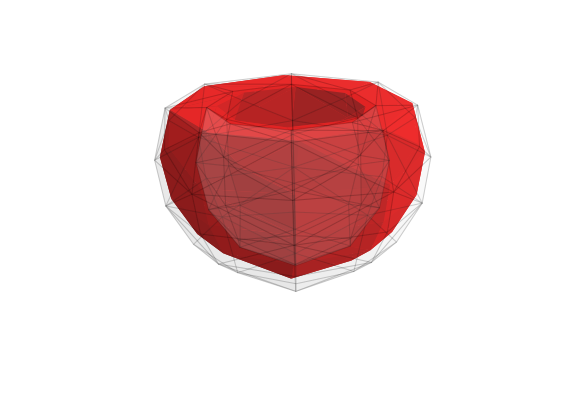

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import dolfin
import pulse
plt.rcParams["figure.figsize"] = (10,8)

geometry = pulse.Geometry.from_file(pulse.mesh_paths['simple_ellipsoid'])
# Plot geometry
# dolfin.plot(geometry.mesh, edgecolor="k", color="w")
# ax = plt.gca()
# ax.view_init(elev=-67, azim=-179)
# ax.set_axis_off()
# plt.show()

activation = dolfin.Function(dolfin.FunctionSpace(geometry.mesh, "R", 0))
activation.assign(dolfin.Constant(0.2))
matparams = pulse.HolzapfelOgden.default_parameters()
material = pulse.HolzapfelOgden(activation=activation,
                                parameters=matparams,
                                f0=geometry.f0,
                                s0=geometry.s0,
                                n0=geometry.n0)

# LV Pressure
lvp = dolfin.Constant(1.0)
lv_marker = geometry.markers['ENDO'][0]
lv_pressure = pulse.NeumannBC(traction=lvp,
                              marker=lv_marker, name='lv')
neumann_bc = [lv_pressure]

# Add spring term at the base with stiffness 1.0 kPa/cm^2
base_spring = 1.0
robin_bc = [pulse.RobinBC(value=dolfin.Constant(base_spring),
                          marker=geometry.markers["BASE"][0])]


# Fix the basal plane in the longitudinal direction
# 0 in V.sub(0) refers to x-direction, which is the longitudinal direction
def fix_basal_plane(W):
    V = W if W.sub(0).num_sub_spaces() == 0 else W.sub(0)
    bc = dolfin.DirichletBC(V.sub(0),
                            dolfin.Constant(0.0),
                            geometry.ffun, geometry.markers["BASE"][0])
    return bc


dirichlet_bc = [fix_basal_plane]
# You can also use a built in function for this
# from functools import partial
# dirichlet_bc = partial(pulse.mechanicsproblem.dirichlet_fix_base_directional,
#                        ffun=geometry.ffun,
#                        marker=geometry.markers["BASE"][0])

# Collect boundary conditions
bcs = pulse.BoundaryConditions(dirichlet=dirichlet_bc,
                               neumann=neumann_bc,
                               robin=robin_bc)

# Create the problem
problem = pulse.MechanicsProblem(geometry, material, bcs)

# Solve the problem
problem.solve()

# Get the solution
u, p = problem.state.split(deepcopy=True)

# Move mesh accoring to displacement
u_int = dolfin.interpolate(u,
                           dolfin.VectorFunctionSpace(geometry.mesh, "CG", 1))
mesh = dolfin.Mesh(geometry.mesh)
dolfin.ALE.move(mesh, u_int)

# Plot the result on to of the original
dolfin.plot(geometry.mesh, alpha=0.1, edgecolor='k', color='w')
dolfin.plot(mesh, color="r")

ax = plt.gca()
ax.view_init(elev=-67, azim=-179)
ax.set_axis_off()
plt.show()